# Homework 5 - CNNs, AEs, GANs
10/21/2022
Author: Matt Uryga




## Task 1 - CNNs

### Part 1 - Simple CNN

### Exploratory Data Analysis
I decided to use the CIFAR10 dataset for this assignment. The dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from tqdm import tqdm
# from models import Conv_Model, MobileNet_Model

In [5]:
# constants
num_workers = 4
batch_size = 128
num_epochs = 15
learning_rate = 0.001
progress_bar = True
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cuda:0


In [6]:
def get_loaders(transforms):
    train_dataset = torchvision.datasets.CIFAR10('../datasets/', train=True, download=True, transform=transforms)
    _dataset = torchvision.datasets.CIFAR10('../datasets/', train=False, download=True, transform=transforms)

    # split nontraining dataset into validation and testing datasets
    nontrain_length = len(_dataset)//2
    valid_dataset, test_dataset = torch.utils.data.random_split(_dataset, [nontrain_length, nontrain_length], generator=torch.Generator().manual_seed(0))

    # create dataloaders
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, num_workers = 2, shuffle = False, persistent_workers = True)
    valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size, num_workers = 2, shuffle = False, persistent_workers = True)
    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, num_workers = 1, shuffle = False, persistent_workers = True)

    return train_loader, valid_loader, test_loader

The non-training dataset (10,000 images and labels) is split into 2 sets: validation and testing (5,000 images and labels each).

In [29]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.225, 0.225, 0.225])
convert = torchvision.transforms.ConvertImageDtype(torch.float)
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), convert])
train_loader, valid_loader, test_loader = get_loaders(transforms)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
imgs, labs = next(iter(train_loader))
print(f'{imgs.shape = }')
print(f'{labs.shape = }')

imgs.shape = torch.Size([128, 3, 32, 32])
labs.shape = torch.Size([128])


Each batch is of size 128, and the images are in the shape of (color_channels, width, height).
They are square, 32x32 images with RGB color channels.  The labels are a single integer from 0-9 representing the class.

In [31]:
import torchvision.transforms.functional
def show(imgs):
	if not isinstance(imgs, list):
		imgs = [imgs]
	fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
	for i, img in enumerate(imgs):
		img = img.detach()
		img = torchvision.transforms.functional.to_pil_image(img)
		axs[0, i].imshow(np.asarray(img))
		axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

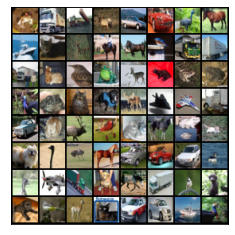

In [36]:
from torchvision.utils import make_grid
grid = make_grid(imgs[:64])
show(grid)

Above are some sample images in the dataset.

In [37]:
def train(model, train_loader, valid_loader):
	# initialize optimizer
	optimizer = optim.Adam(model.parameters(), lr = learning_rate)

	# initialize loss function
	loss_func = nn.CrossEntropyLoss()

	# prev_loss is used to store validation losses -> training is stopped
	# once validation loss is above a 5-epoch rolling mean
	prev_loss = []

	# iterate for specified number of epochs
	for epoch in range(num_epochs):
		model.train()
		sum_loss = 0
		for batch_idx, (images, labels) in enumerate(tqdm(train_loader, disable = not progress_bar, desc = f'Epoch {epoch:02d}', ncols=60)):
			# send tensors to device
			images, labels = images.to(device), labels.to(device)

			# zero out gradients
			optimizer.zero_grad()

			# forward pass
			preds = model(images)

			# calculate loss
			loss = loss_func(preds, labels)
			sum_loss += loss.item()

			# backward pass
			loss.backward()

			# step optimizer
			optimizer.step()

		print(f'\tTrain loss =      {sum_loss/(batch_idx+1)/batch_size:.6f}')

		# validation loop
		model.eval()
		valid_loss = 0
		with torch.no_grad():
			for batch_idx, (images, labels) in enumerate(valid_loader):
				# send tensors to device
				images, labels = images.to(device), labels.to(device)

				# forward pass
				preds = model(images)

				# calculate loss
				loss = loss_func(preds, labels)
				valid_loss += loss.item()

		# append current loss to prev_loss list
		prev_loss.append(valid_loss/(batch_idx+1)/batch_size)

		print(f'\tValidation loss = {valid_loss/(batch_idx+1)/batch_size:.6f}')

		# # if valid_loss exceedes the 5-epoch rolling sum, break from training
		if valid_loss/(batch_idx+1)/batch_size > np.mean(prev_loss[-5:]):
			continue

	return model, prev_loss

In [38]:
def test(model, test_loader):
	loss_func = nn.CrossEntropyLoss()

	sum_loss = 0
	num_correct = 0
	total = 0
	model.eval()
	with torch.no_grad():
		for batch_idx, (images, labels) in enumerate(tqdm(test_loader, disable = not progress_bar, desc = 'Testing', ncols=60)):
			# send tensors to device
			images, labels = images.to(device), labels.to(device)

			# forward pass
			preds = model(images)

			# calculate loss
			# loss = loss_func(preds.float(), F.one_hot(labels, num_classes = 10).float())
			loss = loss_func(preds, labels)
			sum_loss += loss.item()

			# calc number correct
			preds = torch.argmax(preds, dim = 1)
			num_correct += torch.sum(preds == labels)
			total += len(preds)

	print(f'Test loss: {sum_loss/(batch_idx+1)/batch_size:.6f}')
	print(f'Test acc:  {num_correct/total:.6f}')
	return sum_loss

In [42]:
class FFN_Model(nn.Module):
	def __init__(self, in_dim, hidden_dim, out_dim, p = 0.5):
		super().__init__()
		self.flatten = nn.Flatten()
		self.fc1 = nn.Linear(in_dim, hidden_dim*2)
		self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
		self.fc3 = nn.Linear(hidden_dim, out_dim)
		self.dropout1 = nn.Dropout(p = p)
		self.dropout2 = nn.Dropout(p = p)

	def forward(self, x):
		x = self.flatten(x)
		x = self.fc1(x)
		x = F.relu(x)
		x = self.dropout1(x)
		x = self.fc2(x)
		x = F.relu(x)
		x = self.dropout2(x)
		x = self.fc3(x)
		return x

class Conv_Model(nn.Module):
	def __init__(self, in_dim, hidden_dim, out_dim):
		super().__init__()
		self.conv1 = nn.Conv2d(3, 6, 4, padding = 2)
		self.maxpool1 = nn.MaxPool2d(2, stride = 2)
		self.conv2 = nn.Conv2d(6, 16, 4)
		self.maxpool2 = nn.MaxPool2d(2, stride = 2)
		self.ffn = FFN_Model(in_dim, hidden_dim, out_dim)

	def forward(self, x):
		x = self.conv1(x)
		x = self.maxpool1(x)
		x = self.conv2(x)
		x = self.maxpool2(x)
		x = self.ffn(x)
		return x

#### Train and Test Convolutional Network

In [39]:
# apply image transforms
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.225, 0.225, 0.225])
convert = torchvision.transforms.ConvertImageDtype(torch.float)
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize, convert])

# get loaders
train_loader, valid_loader, test_loader = get_loaders(transforms)

# create model and send to gpu
Conv_model = Conv_Model(6*6*16, 128, 10)
Conv_model.to(device)

Files already downloaded and verified
Files already downloaded and verified


Conv_Model(
  (conv1): Conv2d(3, 6, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ffn): FFN_Model(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=576, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=10, bias=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
  )
)

The model I implemented consists of 2 convolutional layers, each followed by a maxpool layer.  This is then passed through a fully connected linear network with 3 linear layers, 2 dropout layers, and ReLu as the activation functions.  It is loosely based off of the simple image classification network, LeNet, with some varied parameters.

In [40]:
Conv_model, Conv_losses = train(Conv_model, train_loader, valid_loader)
Conv_loss = test(Conv_model, test_loader)

Epoch 00: 100%|███████████| 391/391 [00:13<00:00, 29.04it/s]


	Train loss =      0.013257
	Validation loss = 0.010616


Epoch 01: 100%|███████████| 391/391 [00:06<00:00, 64.05it/s]


	Train loss =      0.010968
	Validation loss = 0.009489


Epoch 02: 100%|███████████| 391/391 [00:07<00:00, 50.49it/s]


	Train loss =      0.010092
	Validation loss = 0.008849


Epoch 03: 100%|███████████| 391/391 [00:07<00:00, 50.24it/s]


	Train loss =      0.009481
	Validation loss = 0.008500


Epoch 04: 100%|███████████| 391/391 [00:07<00:00, 54.07it/s]


	Train loss =      0.009026
	Validation loss = 0.008129


Epoch 05: 100%|███████████| 391/391 [00:07<00:00, 54.64it/s]


	Train loss =      0.008740
	Validation loss = 0.007947


Epoch 06: 100%|███████████| 391/391 [00:06<00:00, 59.48it/s]


	Train loss =      0.008411
	Validation loss = 0.007814


Epoch 07: 100%|███████████| 391/391 [00:06<00:00, 59.27it/s]


	Train loss =      0.008144
	Validation loss = 0.007702


Epoch 08: 100%|███████████| 391/391 [00:06<00:00, 59.38it/s]


	Train loss =      0.007947
	Validation loss = 0.007659


Epoch 09: 100%|███████████| 391/391 [00:06<00:00, 55.93it/s]


	Train loss =      0.007789
	Validation loss = 0.007463


Epoch 10: 100%|███████████| 391/391 [00:06<00:00, 62.47it/s]


	Train loss =      0.007546
	Validation loss = 0.007471


Epoch 11: 100%|███████████| 391/391 [00:06<00:00, 62.55it/s]


	Train loss =      0.007376
	Validation loss = 0.007546


Epoch 12: 100%|███████████| 391/391 [00:06<00:00, 61.00it/s]


	Train loss =      0.007232
	Validation loss = 0.007389


Epoch 13: 100%|███████████| 391/391 [00:06<00:00, 61.23it/s]


	Train loss =      0.007077
	Validation loss = 0.007351


Epoch 14: 100%|███████████| 391/391 [00:06<00:00, 61.54it/s]


	Train loss =      0.006992
	Validation loss = 0.007253


Testing: 100%|██████████████| 40/40 [00:02<00:00, 14.03it/s]

Test loss: 0.007587
Test acc:  0.662400


This model is able to achieve 66.24% test set accuracy in 15 epochs.  Based on validation loss, it is worth noting that longer training would likely result in slightly better accuracy.

## Part 2 - Transfer Learning

The network that I chose to use was MobileNetV2.

In [45]:
class MobileNet_Model(nn.Module):
	def __init__(self):
		super().__init__()
		 # load pretrained weights
		self.pre = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
		# freeze pretrained parameters
		for p in self.pre.parameters():
			p.requires_grad = False
		# pass through feed forward network
		self.ffn = FFN_Model(1000, 32, 10)

	def forward(self, x):
		x = self.pre(x)
		return self.ffn(x)

In [44]:
# get loaders with specified transforms
train_loader, valid_loader, test_loader = get_loaders(MobileNet_V2_Weights.IMAGENET1K_V1.transforms())

# create model and send to gpu
MobileNet_model = MobileNet_Model()
MobileNet_model.to(device)

Files already downloaded and verified
Files already downloaded and verified


MobileNet_Model(
  (pre): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [46]:
MobileNet_model, MobileNet_losses = train(MobileNet_model, train_loader, valid_loader)
MobileNet_loss = test(MobileNet_model, test_loader)

Epoch 00: 100%|███████████| 391/391 [01:53<00:00,  3.44it/s]


	Train loss =      0.011414
	Validation loss = 0.007182


Epoch 01: 100%|███████████| 391/391 [02:01<00:00,  3.21it/s]


	Train loss =      0.009402
	Validation loss = 0.006786


Epoch 02: 100%|███████████| 391/391 [02:05<00:00,  3.10it/s]


	Train loss =      0.008979
	Validation loss = 0.006545


Epoch 03: 100%|███████████| 391/391 [02:05<00:00,  3.12it/s]


	Train loss =      0.008700
	Validation loss = 0.006272


Epoch 04: 100%|███████████| 391/391 [02:14<00:00,  2.91it/s]


	Train loss =      0.008522
	Validation loss = 0.006269


Epoch 05: 100%|███████████| 391/391 [02:06<00:00,  3.09it/s]


	Train loss =      0.008400
	Validation loss = 0.006251


Epoch 06: 100%|███████████| 391/391 [02:12<00:00,  2.94it/s]


	Train loss =      0.008379
	Validation loss = 0.006205


Epoch 07: 100%|███████████| 391/391 [02:13<00:00,  2.92it/s]


	Train loss =      0.008206
	Validation loss = 0.006086


Epoch 08: 100%|███████████| 391/391 [02:09<00:00,  3.02it/s]


	Train loss =      0.008182
	Validation loss = 0.006087


Epoch 09: 100%|███████████| 391/391 [02:10<00:00,  3.00it/s]


	Train loss =      0.008143
	Validation loss = 0.006064


Epoch 10: 100%|███████████| 391/391 [02:12<00:00,  2.95it/s]


	Train loss =      0.008077
	Validation loss = 0.006040


Epoch 11: 100%|███████████| 391/391 [02:13<00:00,  2.92it/s]


	Train loss =      0.008067
	Validation loss = 0.005921


Epoch 12: 100%|███████████| 391/391 [02:09<00:00,  3.03it/s]


	Train loss =      0.008037
	Validation loss = 0.005982


Epoch 13: 100%|███████████| 391/391 [02:14<00:00,  2.90it/s]


	Train loss =      0.007971
	Validation loss = 0.005950


Epoch 14: 100%|███████████| 391/391 [02:23<00:00,  2.73it/s]


	Train loss =      0.007936
	Validation loss = 0.005937


Testing: 100%|██████████████| 40/40 [00:27<00:00,  1.44it/s]

Test loss: 0.006139
Test acc:  0.748000


The accuracy for the MobileNetV2 model is significantly higher than the accuracy for the small convolutional model.  It acheives approx. 8.5% greater accuracy, although it takes several times longer to train.  This is most likely due to the much greater number of parameters in the MobileNetV2 model.  There are many more convolutional layers, and they have many, many more channels than the simple model.  This allows for it to more effectively classify images.

## Part 3 - Data Augmentation

I chose to use a variety of affine transformations to augment the dataset.
Specifically, I am using -45 to +45 degree rotations, -20% to +20% translations in x and y axes, and 90% to 110% scale factor.

In [48]:
# affine transformations -> -45 to +45 degree rotations, -20% to +20% translations in x and y axes, and 90% to 110% scale factor
affine = torchvision.transforms.RandomAffine(45, translate = (0.2, 0.2), scale = (0.9, 1.1))

# same transformations from earlier
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.225, 0.225, 0.225])
convert = torchvision.transforms.ConvertImageDtype(torch.float)
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize, convert, affine])
train_loader, valid_loader, test_loader = get_loaders(transforms)

# create model and send to gpu
Conv_model = Conv_Model(6*6*16, 128, 10)
Conv_model.to(device)

Files already downloaded and verified
Files already downloaded and verified


Conv_Model(
  (conv1): Conv2d(3, 6, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ffn): FFN_Model(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=576, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=10, bias=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
  )
)

In [49]:
Conv_model, Conv_losses = train(Conv_model, train_loader, valid_loader)
Conv_loss = test(Conv_model, test_loader)

Epoch 00: 100%|███████████| 391/391 [00:31<00:00, 12.43it/s]


	Train loss =      0.015155
	Validation loss = 0.013603


Epoch 01: 100%|███████████| 391/391 [00:23<00:00, 16.41it/s]


	Train loss =      0.013878
	Validation loss = 0.012729


Epoch 02: 100%|███████████| 391/391 [00:24<00:00, 16.11it/s]


	Train loss =      0.013433
	Validation loss = 0.012581


Epoch 03: 100%|███████████| 391/391 [00:24<00:00, 15.76it/s]


	Train loss =      0.013133
	Validation loss = 0.012254


Epoch 04: 100%|███████████| 391/391 [00:24<00:00, 16.26it/s]


	Train loss =      0.012867
	Validation loss = 0.011877


Epoch 05: 100%|███████████| 391/391 [00:25<00:00, 15.29it/s]


	Train loss =      0.012720
	Validation loss = 0.011704


Epoch 06: 100%|███████████| 391/391 [00:24<00:00, 16.25it/s]


	Train loss =      0.012562
	Validation loss = 0.011611


Epoch 07: 100%|███████████| 391/391 [00:23<00:00, 16.55it/s]


	Train loss =      0.012498
	Validation loss = 0.011527


Epoch 08: 100%|███████████| 391/391 [00:24<00:00, 15.96it/s]


	Train loss =      0.012420
	Validation loss = 0.011477


Epoch 09: 100%|███████████| 391/391 [00:24<00:00, 15.77it/s]


	Train loss =      0.012322
	Validation loss = 0.011440


Epoch 10: 100%|███████████| 391/391 [00:22<00:00, 17.12it/s]


	Train loss =      0.012235
	Validation loss = 0.011195


Epoch 11: 100%|███████████| 391/391 [00:23<00:00, 16.51it/s]


	Train loss =      0.012198
	Validation loss = 0.011292


Epoch 12: 100%|███████████| 391/391 [00:21<00:00, 17.92it/s]


	Train loss =      0.012129
	Validation loss = 0.011114


Epoch 13: 100%|███████████| 391/391 [00:22<00:00, 17.59it/s]


	Train loss =      0.012088
	Validation loss = 0.010967


Epoch 14: 100%|███████████| 391/391 [00:22<00:00, 17.19it/s]


	Train loss =      0.011999
	Validation loss = 0.010924


Testing: 100%|██████████████| 40/40 [00:06<00:00,  6.60it/s]

Test loss: 0.011210
Test acc:  0.483600


The testing accuracy with the augmented data is approx. 18% worse than the unaugmented data.  This is most likely due to the nature of the images and the affine transformations being applied.
The training and testing dataset is composed of almost entirely centered, similar sized objects, and the affine transformations being applied shift the object within the image.  This is likely decreasing the accuracy of the model on the training set.

# Task 2 - VAE and GANs

## Part 1 - VAE

I chose to use the FasionMNIST dataset for this task.  It consists of 60,000 training images and 10,000 testing images, and there are 10 classes.

In [54]:
# load datasets
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,),(0.5,)),])
train_dataset = torchvision.datasets.FashionMNIST("./data", download = True, transform = transform)
test_dataset = torchvision.datasets.FashionMNIST("./data", download = True, train = False, transform = transform)

# print sizes of datasets
print('Before Split')
print(f'\t{len(train_dataset) = }')
print(f'\t{len(test_dataset) = }')

# no validation/dev set, so we create one from training data
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

# print sizes of datasets
print('After Split')
print(f'\t{len(train_dataset) = }')
print(f'\t{len(valid_dataset) = }')
print(f'\t{len(test_dataset) = }')

# initialize dataloaders
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Before Split
	len(train_dataset) = 60000
	len(test_dataset) = 10000
After Split
	len(train_dataset) = 50000
	len(valid_dataset) = 10000
	len(test_dataset) = 10000


Batch Shape = torch.Size([128, 1, 28, 28])


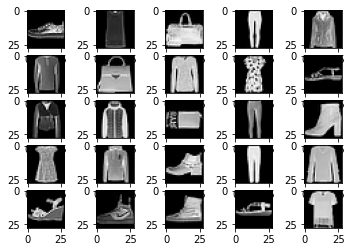

<Figure size 432x288 with 0 Axes>

In [55]:
# print shape of batch
print(f'Batch Shape = {next(iter(train_loader))[0].shape}')

# display some images
fig, ax = plt.subplots(5,5)
for i in range(0, 5):
	for j in range(0, 5):
		ax[i][j].imshow(train_dataset[5*i+j][0].squeeze(), cmap='gray')
plt.show()
plt.clf()

In [65]:
class VAE(nn.Module):
	'''
	Variational Autoencoder as described in https://towardsdatascience.com/building-a-convolutional-vae-in-pytorch-a0f54c947f71
	'''
	def __init__(self, in_channels, feature_dim = 32*20*20, hidden_dim = 256):
		super(VAE, self).__init__()
		# encoder
		self.enc_conv1 = nn.Conv2d(in_channels, 16, 5)
		self.enc_conv2 = nn.Conv2d(16, 32, 5)
		self.enc_fc1 = nn.Linear(feature_dim, hidden_dim)
		self.enc_fc2 = nn.Linear(feature_dim, hidden_dim)

		# decoder
		self.dec_fc1 = nn.Linear(hidden_dim, feature_dim)
		self.dec_conv1 = nn.ConvTranspose2d(32, 16, 5)
		self.dec_conv2 = nn.ConvTranspose2d(16, in_channels, 5)

	def encoder(self, x):
		x = F.relu(self.enc_conv1(x))
		x = F.relu(self.enc_conv2(x))
		x = x.view(-1, 32*20*20)
		mu = self.enc_fc1(x)
		logVar = self.enc_fc2(x)
		return mu, logVar

	def reparameterize(self, mu, logVar):
		std = torch.exp(logVar/2)
		eps = torch.randn_like(std)
		return mu + std * eps

	def decoder(self, z):
		x = F.relu(self.dec_fc1(z))
		x = x.view(-1, 32, 20, 20)
		x = F.relu(self.dec_conv1(x))
		x = torch.sigmoid(self.dec_conv2(x))
		return x

	def forward(self, x):
		mu, logVar = self.encoder(x)
		z = self.reparameterize(mu, logVar)
		out = self.decoder(z)
		return out, mu, logVar

In [66]:
vae = VAE(1).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

In [ ]:
prev_loss = []
for epoch in range(num_epochs):
	vae.train()
	sum_loss = 0
	for batch_idx, (images, labels) in enumerate(tqdm(train_loader, disable = not progress_bar, desc = f'Epoch {epoch:02d}', ncols=60)):
		# send tensors to device
		images, labels = images.to(device), labels.to(device)

		# zero out gradients
		optimizer.zero_grad()

		# forward pass
		out, mu, logVar = vae(images)

		# calculate loss
		kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
		loss = F.binary_cross_entropy(out, images, size_average=False) + kl_divergence
		sum_loss += loss.item()

		# backward pass
		loss.backward()

		# step optimizer
		optimizer.step()
	print(f'\tTrain loss =      {sum_loss/(batch_idx+1)/batch_size:.6f}')

	vae.eval()
	valid_loss = 0
	with torch.no_grad():
		for batch_idx, (images, labels) in enumerate(valid_loader):
			# send tensors to device
			images, labels = images.to(device), labels.to(device)

			# forward pass
			out, mu, logVar = vae(images)

			# calculate loss
			kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
			loss = F.binary_cross_entropy(out, images, size_average=False) + kl_divergence
			valid_loss += loss.item()

	# append current loss to prev_loss list
	prev_loss.append(valid_loss)

	print(f'\tValidation loss = {valid_loss/(batch_idx+1)/batch_size:.6f}')

	# if valid_loss exceedes the 5-epoch rolling sum, break from training
	if valid_loss > np.mean(prev_loss[-5:]):
		continue

Epoch 00: 100%|███████████| 391/391 [00:14<00:00, 26.74it/s]


	Train loss =      -38060.340648
	Validation loss = -38631.453514


Epoch 01: 100%|███████████| 391/391 [00:13<00:00, 29.49it/s]


	Train loss =      -39439.755849
	Validation loss = -38872.925386


Epoch 02: 100%|███████████| 391/391 [00:13<00:00, 29.95it/s]


	Train loss =      -40310.594789
	Validation loss = -40654.743782


Epoch 03: 100%|███████████| 391/391 [00:13<00:00, 29.84it/s]


	Train loss =      -40990.126494
	Validation loss = -40430.600431


Epoch 04: 100%|███████████| 391/391 [00:15<00:00, 24.82it/s]


	Train loss =      -41543.837116
	Validation loss = -41640.633214


Epoch 05: 100%|███████████| 391/391 [00:16<00:00, 24.12it/s]


	Train loss =      -42042.797145
	Validation loss = -41736.794069


Epoch 06: 100%|███████████| 391/391 [00:14<00:00, 27.79it/s]


	Train loss =      -42472.513827
	Validation loss = -42053.179749


Epoch 07:  30%|███▎       | 117/391 [00:04<00:09, 29.19it/s]

In [ ]:
i = 0
fig, ax = plt.subplots(2, 8)
net.eval()
with torch.no_grad():
	for data in random.sample(list(test_loader), 1):
		imgs, _ = data
		imgs = imgs.to(device)
		img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
		ax[0,i].imshow(np.squeeze(img))
		out, mu, logVAR = net(imgs)
		outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
		ax[1,i].imshow(np.squeeze(outimg))
		if i > 8:
			break
		i += 1
plt.show()

## Part 2 - GAN